In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pre
from sklearn.linear_model import LinearRegression, ARDRegression, RANSACRegressor, TheilSenRegressor, Ridge, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_approximation import Nystroem
import os
import matplotlib.patches as mpatch
from matplotlib.lines import Line2D

mse_score = metrics.make_scorer(metrics.mean_squared_error, 
                                greater_is_better=False)

X_val = pd.read_csv("test_selected.csv")
X_val.pop("id")
y_val = [int(line) for line in open("PM_truth.txt", "r").readlines()]

def data_split(smooth=False):
    data = pd.read_csv("train_selected.csv")
    label=data.pop("ttf")
    if smooth:
        sm_s1, sm_s2, sm_s3, sm_s4 = list(),list(),list(),list()
        for engine, group in data.groupby("id"):
            sm_s1.extend(savgol_filter(group["s1"],25,1))
            sm_s2.extend(savgol_filter(group["s2"],25,1))
            sm_s3.extend(savgol_filter(group["s3"],25,1))
            sm_s4.extend(savgol_filter(group["s4"],25,1))
        data["sm_s1"] = sm_s1
        data["sm_s2"] = sm_s2
        data["sm_s3"] = sm_s3
        data["sm_s4"] = sm_s4
        return data[["cycle","sm_s1","sm_s2","sm_s3","sm_s4"]], label
    else:
        return data[["cycle","s1","s2","s3","s4"]], label

def paramplot(gs,yval="mean_test_score"):
    df = pd.DataFrame.from_dict(gs.cv_results_)
    for column in df:
        if column[:6] == "param_":
            df.plot(y=yval,x=column,kind="scatter")
            
def assemble_estimators(container,number):
    models, scores = list(),list()
    container = [name for name in container if name not in ["Voter","Stacker", 
                                                            "Voter_Smooth", "Stacker_Smooth",
                                                           "Stacking","Stacking_Smooth"]]
    for name in container:
        file = open(r"regressors/{}.pkl".format(name),'rb')
        model = pickle.load(file)
        file.close()
        models.append(model)
        scores.append(metrics.mean_squared_error(y_val,model.predict(X_val),squared=False))
    leaderboard=pd.DataFrame(list(zip(container, models, scores)), 
               columns =['Name', 'Model', 'RMSE'])
    leaderboard = leaderboard.sort_values(by="RMSE").reset_index()
    estimators = list()
    for i in range(number): 
        print(leaderboard["Name"][i])
        estimators.append((leaderboard["Name"][i],leaderboard["Model"][i]))
    return estimators

def validate(model,name,save=True):
    pred_val = model.predict(X_val)
    mse = metrics.mean_squared_error(y_val,pred_val,squared=False)
    mae = metrics.mean_absolute_error(y_val,pred_val)
    print(model)
    print("VALIDATION DATA\nRMSE score: {}\nMAE score: {}".format(mse,mae))
    if save:
        file = 'regressors/{}.pkl'.format(name)
        try:
            old = pickle.load(open(file,"rb"))
            old_score = metrics.mean_squared_error(y_val,old.predict(X_val),squared=False)
            #new_score = metrics.mean_squared_error(y_val,model.predict(X_val),squared=False)
            if mse < old_score:
                pickle.dump(model, open(file,'wb'))
                print("New best score - model saved.")
            else: 
                print("No improvement observed. Current leading model at {}:\n{}".format(old_score,old))
        except:
            pickle.dump(model, open(file,'wb'))
            print("Model saved")
    return mse

def fit_validate(pipeline,params,name,smooth=False,save=True):
    gs = GridSearchCV(
                  pipeline, params,
                  verbose=10, n_jobs=-1,
                  scoring=mse_score,
                )
    X_train, y_train = data_split(smooth)
    print(name)
    gs.fit(X_train,y_train)
    model = gs.best_estimator_
    resultplot(model,name)
    return validate(model,name,save=save)

def resultplot(model,name):
    f, (ax1,ax2) = plt.subplots(ncols=2,
                                sharey=False,
                                figsize=(12,4))
    pred_val = model.predict(X_val)
    rmse = round(metrics.mean_squared_error(y_val, 
                                            pred_val, 
                                            squared=False),2)
    ax1.scatter(x=y_val,y=pred_val,marker=".")
    ax1.plot(y_val,y_val,color="r",linestyle="--")
    ax1.set_xlabel("Truth")
    ax1.set_ylabel("Prediction")
    ax1.set_title("{}\nRMSE {}".format(name,rmse))

    difference = [p-y for y,p in zip(y_val,pred_val)]
    data = pd.DataFrame(difference,
                        columns=["Error"])
    ax2 = sns.histplot(data=data, 
                        x="Error", 
                        kde=True,
                        ax=ax2)
    ax2.set_title("Prediction Error Distribution: {}\nSTD: {}".format(name,
                                                                      round(data["Error"].std(),2)))
    plt.show

# Linear Regression

LinearRegression_Smooth
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures()),
                ('pca', PCA(n_components=4)), ('lrg', LinearRegression())])
VALIDATION DATA
RMSE score: 30.20759611784825
MAE score: 24.19349916305118
No improvement observed. Current leading model at 28.366748183479363:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('rsc', LinearRegression())])
LinearRegression
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures(degree=1)),
                ('pca', PCA(n_components=2)), ('lrg', LinearRegression())])
VALIDATION DATA
RMSE score: 32.58580548196586
MAE score: 27.043951665309297
No improvement observed. Current leading model at 28.11001553770353:
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures()),
           

32.58580548196586

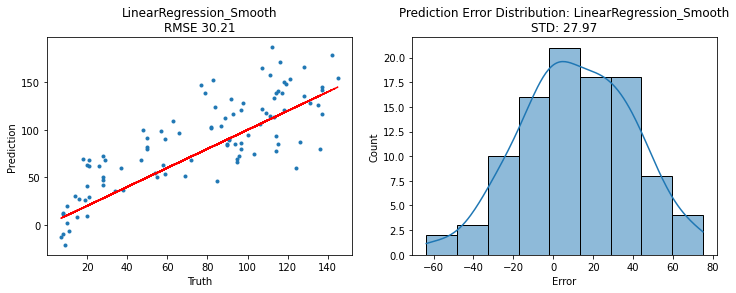

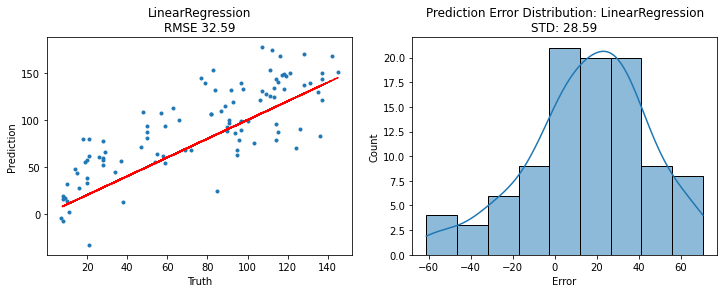

In [13]:
pipeline = Pipeline([
                ('ss', pre.StandardScaler()),
                ('pfs', PolynomialFeatures()),
                ('pca', PCA()),
                ('lrg', LinearRegression()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':(1,2,3,4),
        }

fit_validate(pipeline,params,"LinearRegression_Smooth",True)
fit_validate(pipeline,params,"LinearRegression",False)

# Stochastic Gradient Descent

SGD_Smooth
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures(degree=1)),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('sgd', SGDRegressor())])
VALIDATION DATA
RMSE score: 32.80245059307491
MAE score: 26.952088908796437
No improvement observed. Current leading model at 30.04093285459722:
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures()),
                ('pca', PCA(n_components=4)), ('sgd', SGDRegressor())])
SGD
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures(degree=1)),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('sgd', SGDRegressor())])
VALIDATION DATA
RMSE score: 32.21643685800964
MAE score: 26.783080572101834
No improvement observed. Current leading model at 31.527064166036173:
Pipeline(steps=[('ss', StandardScaler()), ('pfs

32.21643685800964

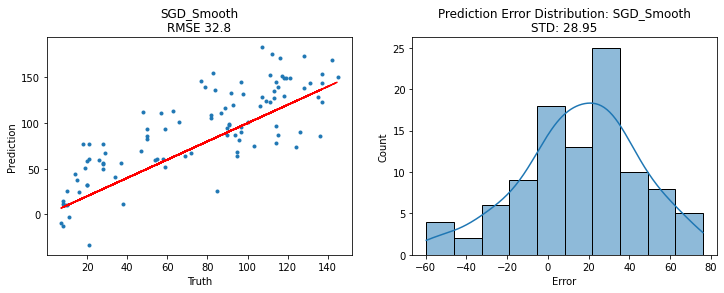

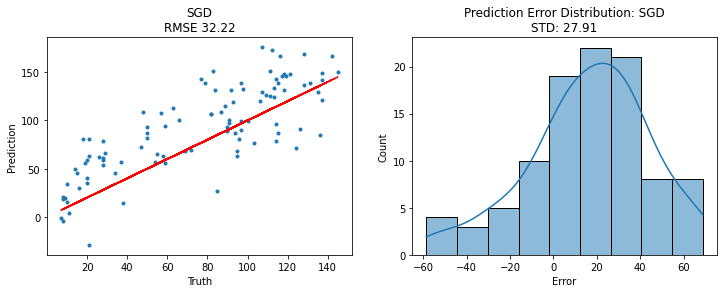

In [14]:
pipeline = Pipeline([
                ('ss', pre.StandardScaler()),
                ('pfs', PolynomialFeatures()),
                ('pca', PCA()),
                ('sgd', SGDRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            #'pca__n_components':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'sgd__loss':('huber',
                         'squared_loss',
                         'epsilon_insensitive',
                         'squared_epsilon_insensitive',
                        )}
                 
fit_validate(pipeline,params,"SGD_Smooth",True)
fit_validate(pipeline,params,"SGD",False)

# Radius Neighbours Regressor

Radius_Smooth
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rnr', RadiusNeighborsRegressor(radius=1.2))])
VALIDATION DATA
RMSE score: 29.692539254518532
MAE score: 23.08510819668842
No improvement observed. Current leading model at 29.692539254518532:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rnr', RadiusNeighborsRegressor(radius=1.2))])
Radius
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rnr', RadiusNeighborsRegressor(radius=1.2))])
VALIDATION DATA
RMSE score: 28.372289923850207
MAE score: 22.728958362071225
No improvement obser

28.372289923850207

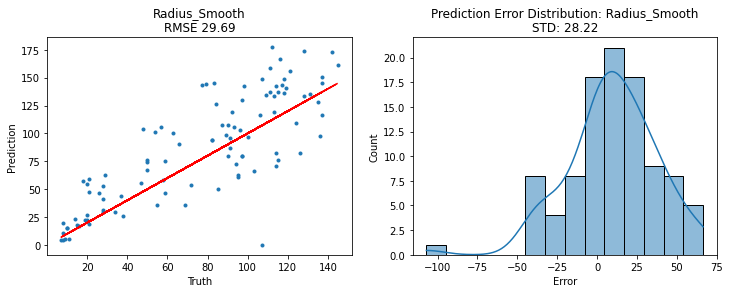

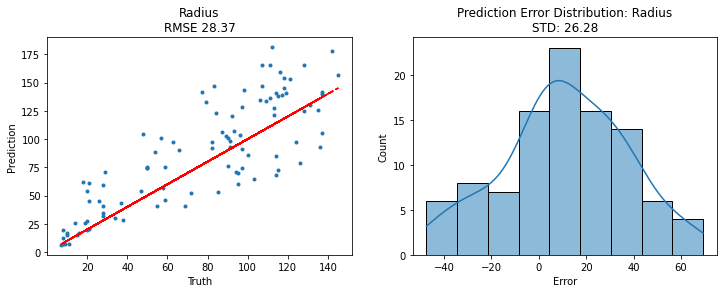

In [15]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('rnr', RadiusNeighborsRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            #'pca__n_components':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'rnr__radius':(0.8,1,1.2),
            'rnr__weights':('uniform','distance'),
            'rnr__algorithm':('auto','ball_tree','kd_tree'),
            }

fit_validate(pipeline,params,"Radius_Smooth",True)
fit_validate(pipeline,params,"Radius",False)

# LinearSVR

LinSVR_Smooth
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('LinSVR', LinearSVR(loss='squared_epsilon_insensitive'))])
VALIDATION DATA
RMSE score: 32.96970787296445
MAE score: 27.106643064111946
No improvement observed. Current leading model at 25.782885265341186:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('LinSVR', LinearSVR())])
LinSVR
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('LinSVR', LinearSVR(loss='squared_epsilon_insensitive'))])
VALIDATION DATA
RMSE score: 32.561422134027076
MAE score: 27.014628854686922
No improvement observed. Current leading model at 29.21371186536542:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), (

32.561422134027076

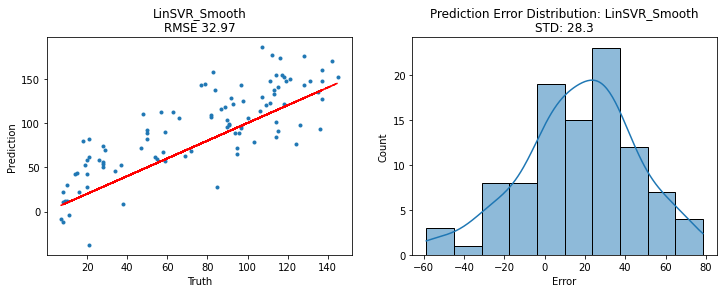

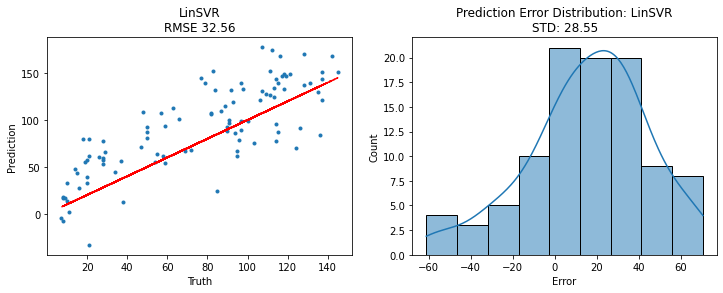

In [16]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                #('nys', Nystroem()),
                ('LinSVR', LinearSVR()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'LinSVR__loss':('epsilon_insensitive','squared_epsilon_insensitive'),
         }
                 
fit_validate(pipeline,params,"LinSVR_Smooth",True)
fit_validate(pipeline,params,"LinSVR",False)

# Decision Tree Regressor

Tree_Smooth
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('dtr', DecisionTreeRegressor(max_features='log2'))])
VALIDATION DATA
RMSE score: 46.6871502664277
MAE score: 33.63
No improvement observed. Current leading model at 45.572140612439966:
Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('dtr',
                 DecisionTreeRegressor(criterion='friedman_mse',
                                       max_features='log2'))])
Tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('dtr', DecisionTreeRegressor(max_features='log2'))])
VALIDATION DATA
RMSE score: 47.863660536987766
MAE score: 32.41
No improvement observed. Current leading mod

47.863660536987766

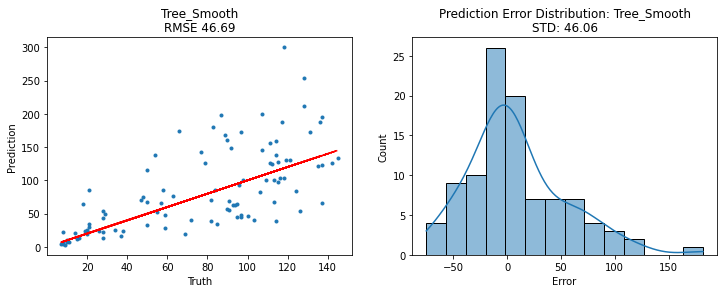

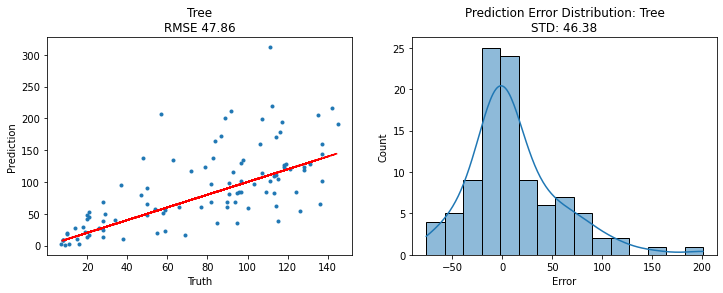

In [17]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('dtr', DecisionTreeRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4,5),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'dtr__criterion':('mse','friedman_mse'),
            'dtr__max_features':('sqrt','log2')
        }

fit_validate(pipeline,params,"Tree_Smooth",True)
fit_validate(pipeline,params,"Tree",False)

# Extra Trees Regressor

ExtraTree_Smooth
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('etr', ExtraTreesRegressor(max_features='log2'))])
VALIDATION DATA
RMSE score: 37.36257598483035
MAE score: 28.086866666666666
No improvement observed. Current leading model at 32.68051494392339:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('etr', ExtraTreesRegressor(max_features='sqrt'))])
ExtraTree
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('etr', ExtraTreesRegressor(max_features='sqrt'))])
VALIDATION DATA
RMSE score: 29.34195951193444
MAE score: 23.497200000000007
New b

29.34195951193444

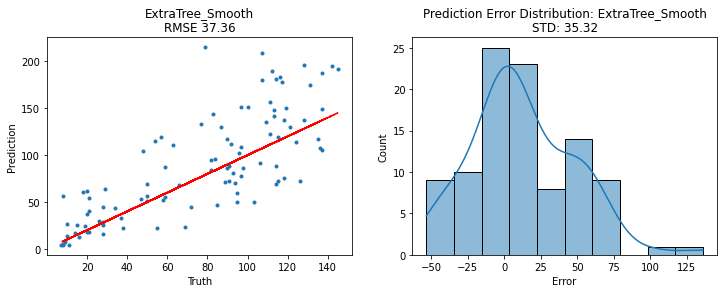

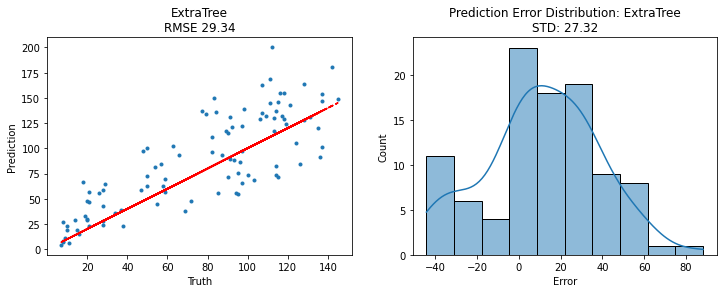

In [18]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('etr', ExtraTreesRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'etr__max_features':('sqrt','log2')
        }

fit_validate(pipeline,params,"ExtraTree_Smooth",True)
fit_validate(pipeline,params,"ExtraTree",False)

# Gradient Boosting

GRB_Smooth
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('grb', GradientBoostingRegressor(loss='lad', random_state=0))])
VALIDATION DATA
RMSE score: 29.76093733346241
MAE score: 22.638708868180515
No improvement observed. Current leading model at 26.247436994681717:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('grb', GradientBoostingRegressor(loss='lad'))])
GRB
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('grb', GradientBoostingRegressor(random_state=0))])
VALIDATION DATA
RMSE score: 27.572082877911036
MAE score: 21.852216693518166
No

27.572082877911036

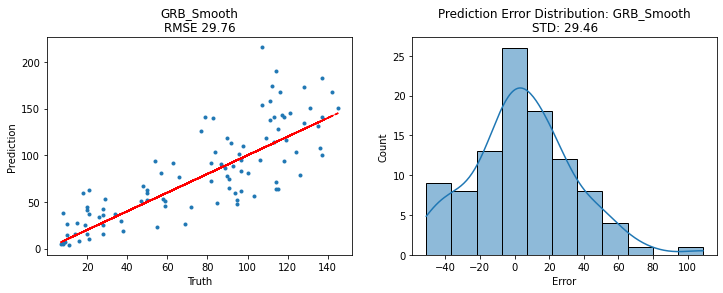

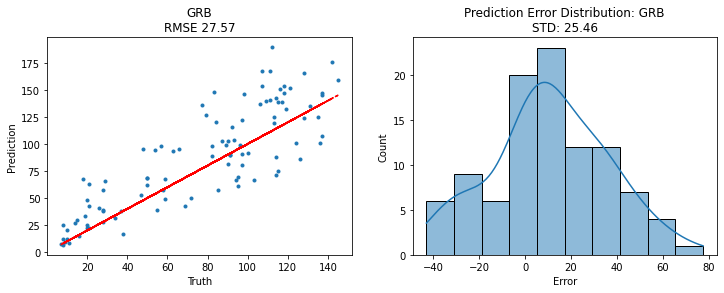

In [19]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('grb', GradientBoostingRegressor(random_state=0)),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'grb__loss':("ls","lad","huber","quantile")
         }
                 
fit_validate(pipeline,params,"GRB_Smooth",True)
fit_validate(pipeline,params,"GRB",False)

# ARD

ARD_Smooth
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('ard', ARDRegression(alpha_1=0.0001))])
VALIDATION DATA
RMSE score: 32.96494008069382
MAE score: 27.10653565434801
No improvement observed. Current leading model at 29.84272538561451:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('ard', ARDRegression(alpha_2=1e-05))])
ARD
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('ard', ARDRegression(alpha_1=0.0001, alpha_2=0.0001))])
VALIDATION DATA
RMSE score: 32.58483658759685
MAE score: 27.04312321161168
No improvement observed. Current leading model at

32.58483658759685

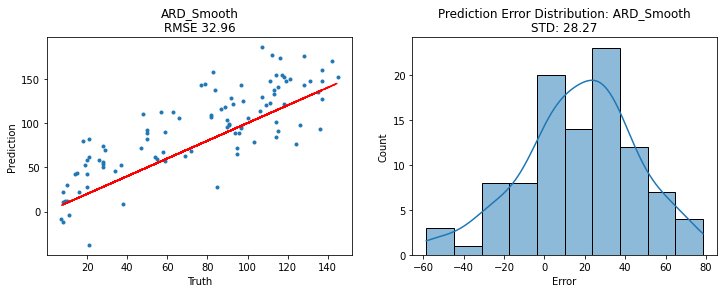

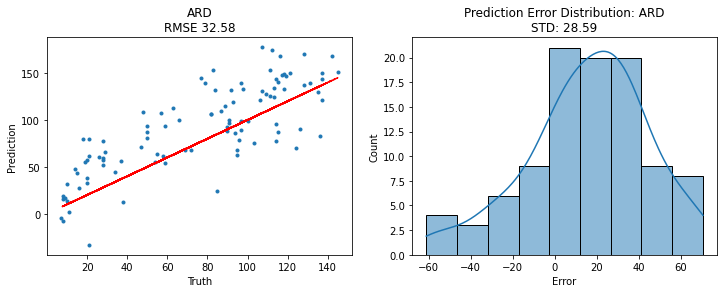

In [20]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('ard', ARDRegression()),
                    ])

params = {
            'pfs__degree':(1,2,3),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'ard__alpha_1':(1e-6,1e-5,1e-4),
            'ard__alpha_2':(1e-6,1e-5,1e-4),
            }
                 
fit_validate(pipeline,params,"ARD_Smooth",True)
fit_validate(pipeline,params,"ARD",False)

# SVR

Full pipeline done
to do:
Raw
Scaled only
No PCA
No PFS

SVR_Smooth
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures(degree=1)),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('nys', Nystroem()), ('svr', SVR(C=3, kernel='linear'))])
VALIDATION DATA
RMSE score: 29.596593325403003
MAE score: 22.85537357635947
No improvement observed. Current leading model at 25.9410398144157:
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures(degree=1)),
                ('pca', PCA(n_components=4)), ('svr', SVR())])
SVR
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures(degree=1)),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('nys', Nystroem()), ('svr', SVR(C=4, kernel='linear'))])
VALIDATION DATA
RMSE score: 27.502139897222243
MAE score: 21.45404200973854
No improvement observed. Current leading model at 26.

27.502139897222243

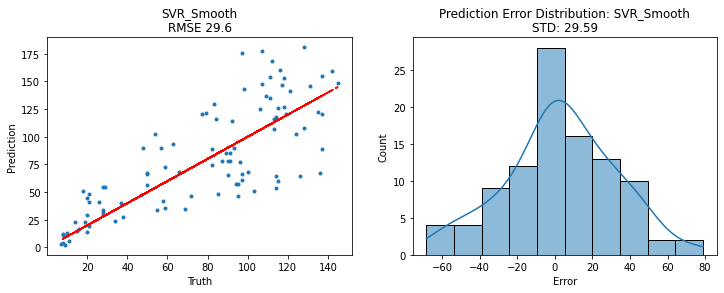

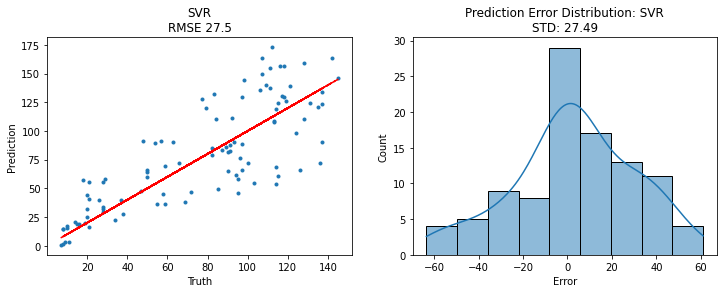

In [27]:
pipeline = Pipeline([
                ('ss', pre.StandardScaler()),
                ('pfs', PolynomialFeatures()),
                ('pca', PCA()),
                ('nys', Nystroem()),
                ('svr', SVR()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'svr__kernel':('linear','rbf'),
            'svr__C':(1,2,3,4),
         }
                 
fit_validate(pipeline,params,"SVR_Smooth",True)
fit_validate(pipeline,params,"SVR",False)

# NuSVR

NuSVR_Smooth
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('nys', Nystroem()), ('nsv', NuSVR(kernel='linear', nu=0.3))])
VALIDATION DATA
RMSE score: 26.897315586912974
MAE score: 23.167576806200415
No improvement observed. Current leading model at 25.446901077957637:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('rsc', NuSVR())])
NuSVR
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('nys', Nystroem()), ('nsv', NuSVR(nu=0.3))])
VALIDATION DATA
RMSE score: 28.86195542365721
MAE score: 25.287795497516903
No improvement observed. Current leading model at 26.30452772490734:


28.86195542365721

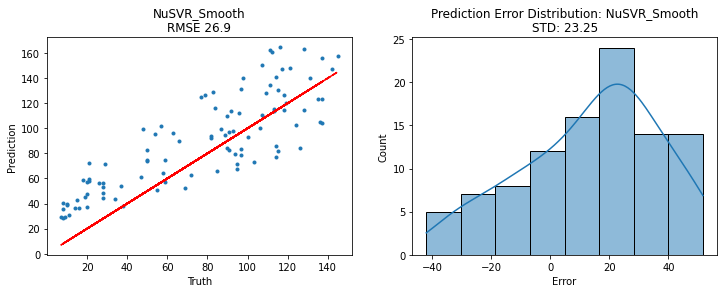

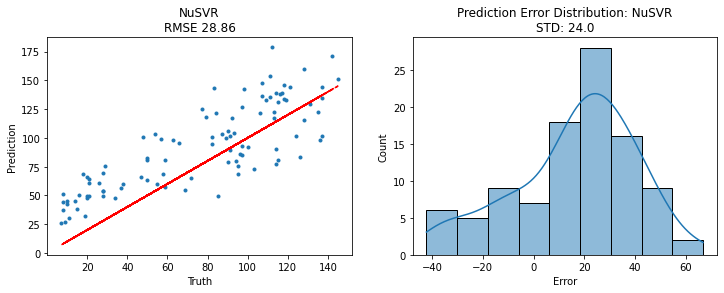

In [26]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('nys', Nystroem()),
                ('nsv', NuSVR()),
                    ])

params = {
            'pfs__degree':(2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'nsv__nu':(0.1,0.2,0.3),
            #'nsv__nu':[i/20 for i in range(1,21,1)],
            'nsv__kernel':('rbf','linear'),
            }

fit_validate(pipeline,params,"NuSVR_Smooth",True)
fit_validate(pipeline,params,"NuSVR",False)

# RANSAC

RANSAC_Smooth
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rsc', RANSACRegressor(random_state=0))])
VALIDATION DATA
RMSE score: 23.818656441151493
MAE score: 19.697834699922126
No improvement observed. Current leading model at 22.070697872000682:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('rsc', RANSACRegressor())])
RANSAC
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rsc', RANSACRegressor(loss='squared_loss', random_state=0))])
VALIDATION DATA
RMSE score: 31.179903369692674
MAE score: 24.890815574442794
No improvement observed. Current leading model at 25.17211

31.179903369692674

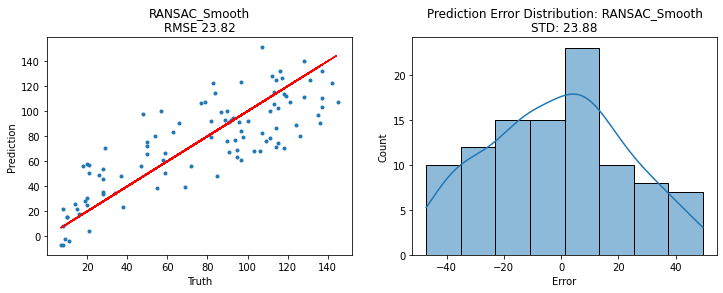

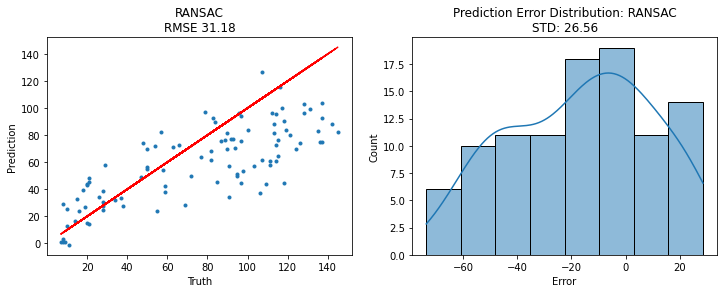

In [22]:

pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('rsc', RANSACRegressor(random_state=0)),
                    ])

params = {
            'pfs__degree':(2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'rsc__loss':('absolute_loss','squared_loss'),
            'rsc__max_trials':(100,200,300),
          }

fit_validate(pipeline,params,"RANSAC_Smooth",True)
fit_validate(pipeline,params,"RANSAC",False)

# TheilSen

Extremely slow. Run when required. 1-3 minutes per fit.

TheilSen_Smooth
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('ths', TheilSenRegressor(max_subpopulation=10000))])
VALIDATION DATA
RMSE score: 29.789900932198222
MAE score: 23.772284709622895
No improvement observed. Current leading model at 27.01431527646258:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('ths', TheilSenRegressor(max_subpopulation=10000))])
TheilSen
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('ths', TheilSenRegressor(max_subpopulation=10000))])
VALIDATION DATA
RMSE score: 29.452782083243857
MAE score: 23.621472467083716
New bes

29.452782083243857

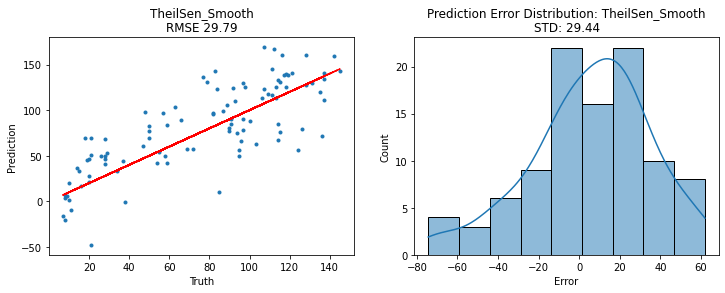

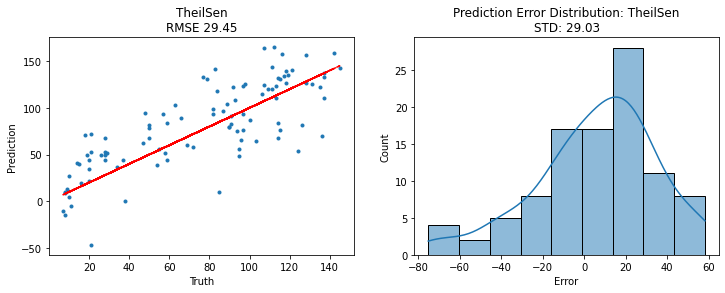

In [31]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('ths', TheilSenRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
        }

fit_validate(pipeline,params,"TheilSen_Smooth",True)
fit_validate(pipeline,params,"TheilSen",False)

# kNN

KNNr_Smooth
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('knr',
                 KNeighborsRegressor(leaf_size=1, n_neighbors=25,
                                     weights='distance'))])
VALIDATION DATA
RMSE score: 35.0586495289311
MAE score: 26.585298784254817
New best score - model saved.
KNNr
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('knr',
                 KNeighborsRegressor(leaf_size=1, n_neighbors=25,
                                     weights='distance'))])
VALIDATION DATA
RMSE score: 28.621149985126358
MAE score: 22.58230127653256
New best score - model saved.


28.621149985126358

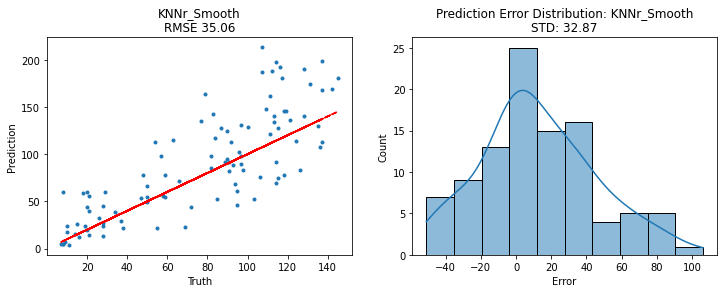

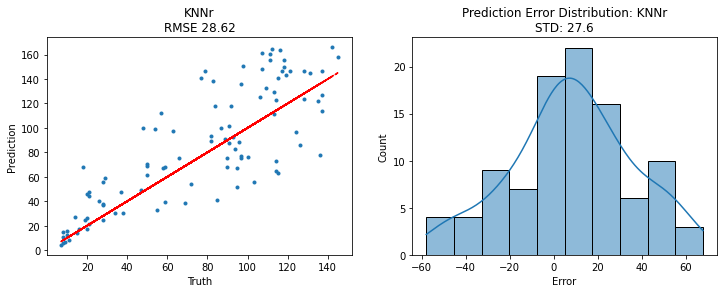

In [28]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('knr', KNeighborsRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'knr__algorithm':('auto','ball_tree','kd_tree'),
            'knr__n_neighbors':(1,5,25),
            'knr__weights':(['distance']),
            'knr__leaf_size':(1,10,100),
        }
                 
fit_validate(pipeline,params,"KNNr_Smooth",True)
fit_validate(pipeline,params,"KNNr",False)

# Random Forest Regressor

RForest_Smooth
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rfr',
                 RandomForestRegressor(max_depth=5, min_samples_leaf=100,
                                       n_estimators=200))])
VALIDATION DATA
RMSE score: 29.386831401076766
MAE score: 23.1022669607076
New best score - model saved.
RForest
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rfr',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=100,
                                       n_estimators=200))])
VALIDATION DATA
RMSE score: 27.6529534098306
MAE score: 22.128469266483112
No improvement observed. Current leading model at 27.20210

27.6529534098306

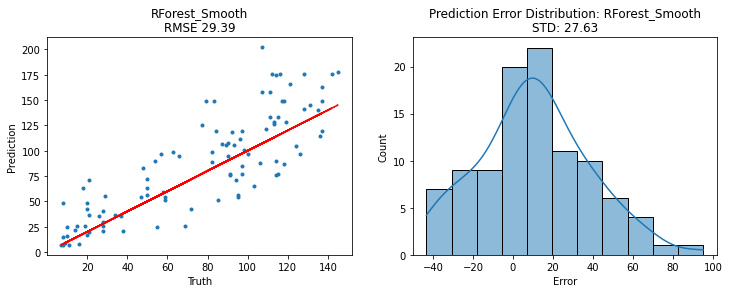

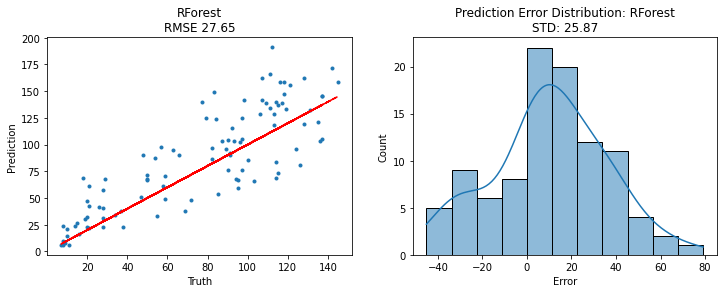

In [29]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('rfr', RandomForestRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'rfr__max_depth':(1,5,10,15),
            'rfr__n_estimators':(50,100,200),
            'rfr__min_samples_leaf':(1,10,100)
        }

fit_validate(pipeline,params,"RForest_Smooth",True)
fit_validate(pipeline,params,"RForest",False)

# AdaBoost

AdaBoost_Smooth
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('ada', AdaBoostRegressor())])
VALIDATION DATA
RMSE score: 34.704479880505296
MAE score: 28.316180833653494
No improvement observed. Current leading model at 33.368974717695814:
Pipeline(steps=[('ss', StandardScaler()), ('ada', AdaBoostRegressor())])
AdaBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('ada', AdaBoostRegressor())])
VALIDATION DATA
RMSE score: 36.1083608867842
MAE score: 29.750334408079713
No improvement observed. Current leading model at 35.44701392956915:
Pipeline(steps=[('ada', AdaBoostRegressor())])


36.1083608867842

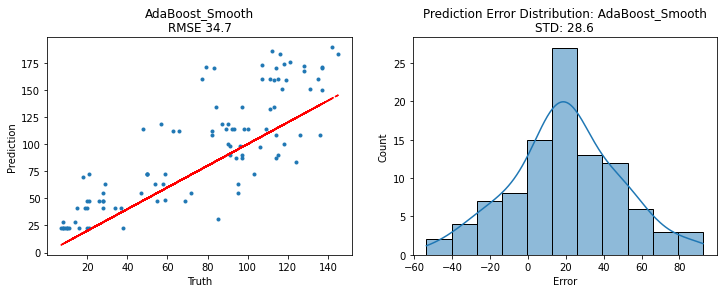

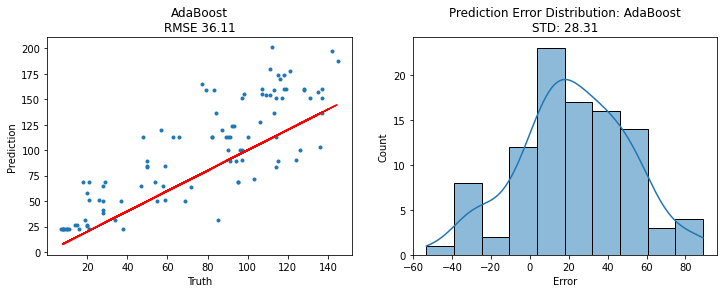

In [30]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('ada', AdaBoostRegressor()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'ada__loss':('linear','square','exponential')
            }

fit_validate(pipeline,params,"AdaBoost_Smooth",True)
fit_validate(pipeline,params,"AdaBoost",False)

# Ridge

Ridge_Smooth
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rdg', Ridge(solver='saga'))])
VALIDATION DATA
RMSE score: 32.96527851963282
MAE score: 27.10788065882707
No improvement observed. Current leading model at 29.32916598442408:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('rdg', Ridge(solver='sparse_cg'))])
Ridge
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('rdg', Ridge(solver='sparse_cg'))])
VALIDATION DATA
RMSE score: 32.57484827427469
MAE score: 27.031140017272428
No improvement observed. Current leading model at 32.33096142768209:
Pipelin

32.57484827427469

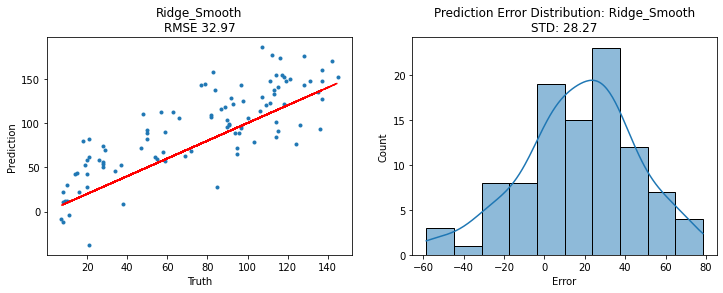

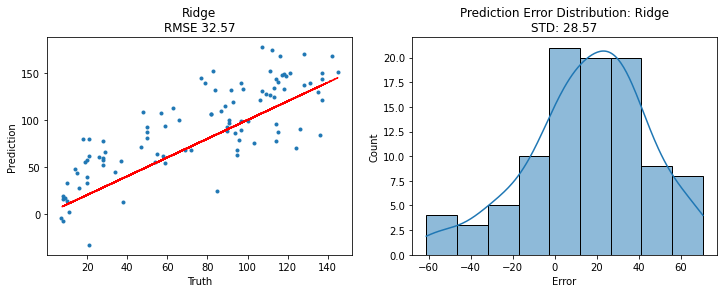

In [32]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('rdg', Ridge()),
                    ])

params = {
            'pfs__degree':(1,2,3,4),
            'pca__n_components':([0.9]),
            'pca__svd_solver':(['full']),
            'rdg__solver':("auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"),
        }
                 
fit_validate(pipeline,params,"Ridge_Smooth",True)
fit_validate(pipeline,params,"Ridge",False)

# ElasticNet

ElasticNet_Smooth
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('eln', ElasticNet())])
VALIDATION DATA
RMSE score: 32.57151727868322
MAE score: 26.78923910296406
No improvement observed. Current leading model at 30.01606875218226:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('eln', ElasticNet())])
ElasticNet
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('eln', ElasticNet())])
VALIDATION DATA
RMSE score: 32.24123397583819
MAE score: 26.90909308607852
No improvement observed. Current leading model at 32.241233975838185:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss

32.24123397583819

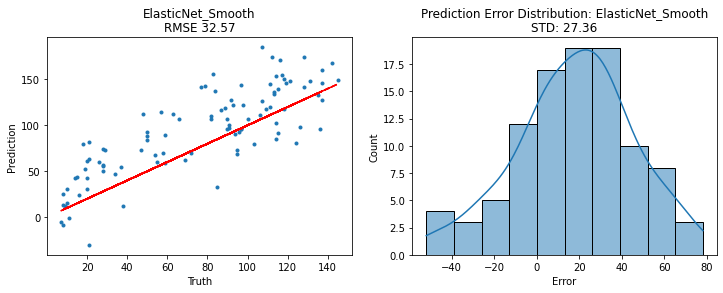

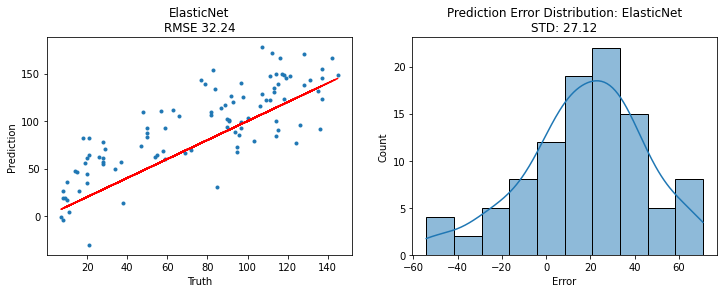

In [34]:
pipeline = Pipeline([
                ('pfs', PolynomialFeatures()),
                ('ss', pre.StandardScaler()),
                ('pca', PCA()),
                ('eln', ElasticNet()),
                    ])

params = {
                'pfs__degree':(1,2,3,4),
                'pca__n_components':([0.9]),
                'pca__svd_solver':(['full']),
                }

fit_validate(pipeline,params,"ElasticNet_Smooth",True)
fit_validate(pipeline,params,"ElasticNet",False)

# Voter

In [35]:
jar = [file.split(".")[0] for file in os.listdir(r"regressors/") if file.split(".")[1] == 'pkl']
smoothjar = [file for file in jar if "mooth" in file and 'RANSAC' not in file]
roughjar = [file for file in jar if "mooth" not in file and 'RANSAC' not in file]

for n in range(2,6):
    estimators = assemble_estimators(smoothjar,n)
    X_train, y_train = data_split(smooth=True)
    model = VotingRegressor(estimators, n_jobs=-1).fit(X_train,y_train)
    validate(model,"Voter_Smooth")

    estimators = assemble_estimators(roughjar,n)
    X_train, y_train = data_split(smooth=False)
    model = VotingRegressor(estimators, n_jobs=-1).fit(X_train,y_train)
    validate(model,"Voter")

NuSVR_Smooth
LinSVR_Smooth
VotingRegressor(estimators=[('NuSVR_Smooth',
                             Pipeline(steps=[('pfs',
                                              PolynomialFeatures(degree=3)),
                                             ('ss', StandardScaler()),
                                             ('pca', PCA(n_components=4)),
                                             ('rsc', NuSVR())])),
                            ('LinSVR_Smooth',
                             Pipeline(steps=[('pfs', PolynomialFeatures()),
                                             ('ss', StandardScaler()),
                                             ('pca', PCA(n_components=4)),
                                             ('LinSVR', LinearSVR())]))],
                n_jobs=-1)
VALIDATION DATA
RMSE score: 25.236843050064447
MAE score: 19.799406184081807
No improvement observed. Current leading model at 25.215906024077565:
VotingRegressor(estimators=[('NuSVR_Smooth',
                         

New best score - model saved.
NuSVR
SVR
RForest
GRB
VotingRegressor(estimators=[('NuSVR',
                             Pipeline(steps=[('pfs', PolynomialFeatures()),
                                             ('ss', StandardScaler()),
                                             ('pca', PCA(n_components=2)),
                                             ('nsv', NuSVR(nu=0.6))])),
                            ('SVR',
                             Pipeline(steps=[('pfs', PolynomialFeatures()),
                                             ('ss', StandardScaler()),
                                             ('pca', PCA(n_components=2)),
                                             ('svr', SVR())])),
                            ('RForest',
                             Pipeline(steps=[('pfs',
                                              PolynomialFeatures(degree=1)),
                                             ('rfr',
                                              RandomForestRegressor(max

No improvement observed. Current leading model at 26.18291250282041:
VotingRegressor(estimators=[('NuSVR',
                             Pipeline(steps=[('pfs', PolynomialFeatures()),
                                             ('ss', StandardScaler()),
                                             ('pca', PCA(n_components=2)),
                                             ('nsv', NuSVR(nu=0.6))])),
                            ('SVR',
                             Pipeline(steps=[('pfs', PolynomialFeatures()),
                                             ('ss', StandardScaler()),
                                             ('pca', PCA(n_components=2)),
                                             ('svr', SVR())])),
                            ('RForest',
                             Pipeline(steps=[('pfs',
                                              PolynomialFeatures(degree=1)),
                                             ('rfr',
                                              RandomFo

# Stacking

NuSVR_Smooth
LinSVR_Smooth
Stacking_Smooth
Fitting 5 folds for each of 11 candidates, totalling 55 fits
StackingRegressor(estimators=[('NuSVR_Smooth',
                               Pipeline(steps=[('pfs',
                                                PolynomialFeatures(degree=3)),
                                               ('ss', StandardScaler()),
                                               ('pca', PCA(n_components=4)),
                                               ('rsc', NuSVR())])),
                              ('LinSVR_Smooth',
                               Pipeline(steps=[('pfs', PolynomialFeatures()),
                                               ('ss', StandardScaler()),
                                               ('pca', PCA(n_components=4)),
                                               ('LinSVR', LinearSVR())]))],
                  final_estimator=Ridge())
VALIDATION DATA
RMSE score: 27.74293266399955
MAE score: 22.188314748908553
New best score - model sav

No improvement observed. Current leading model at 27.74293266399955:
StackingRegressor(estimators=[('NuSVR_Smooth',
                               Pipeline(steps=[('pfs',
                                                PolynomialFeatures(degree=3)),
                                               ('ss', StandardScaler()),
                                               ('pca', PCA(n_components=4)),
                                               ('rsc', NuSVR())])),
                              ('LinSVR_Smooth',
                               Pipeline(steps=[('pfs', PolynomialFeatures()),
                                               ('ss', StandardScaler()),
                                               ('pca', PCA(n_components=4)),
                                               ('LinSVR', LinearSVR())]))],
                  final_estimator=Ridge())
NuSVR
SVR
RForest
GRB
Stacking
Fitting 5 folds for each of 11 candidates, totalling 55 fits
StackingRegressor(estimators=[('NuSVR',
     

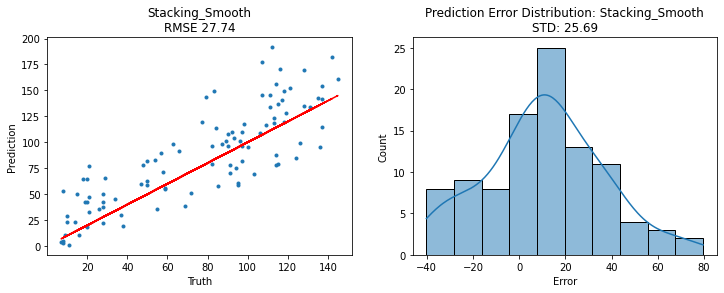

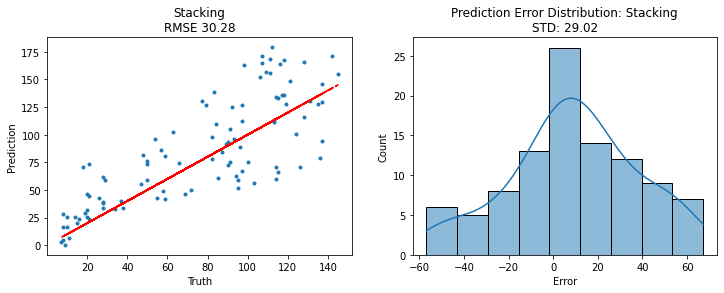

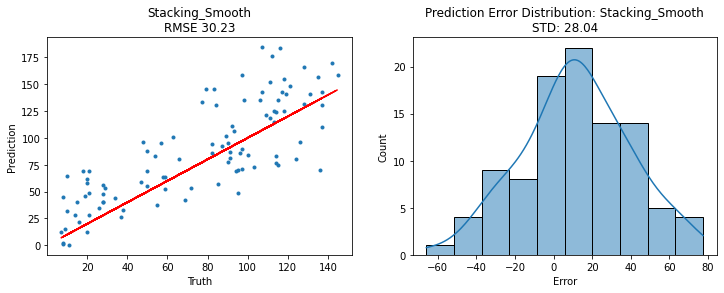

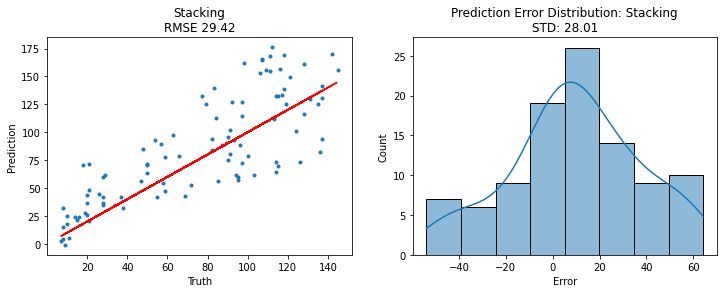

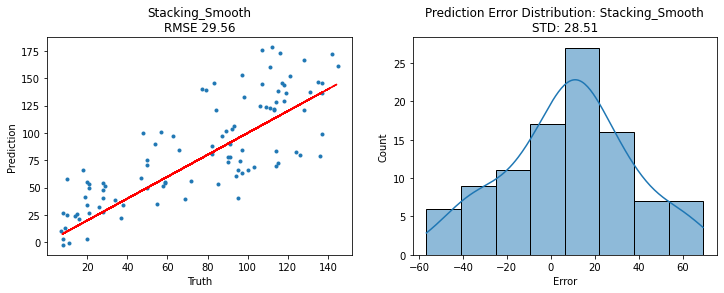

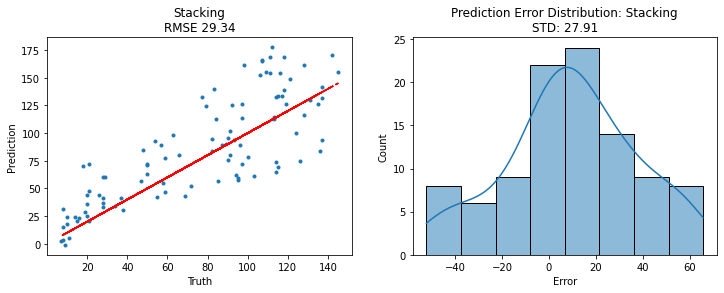

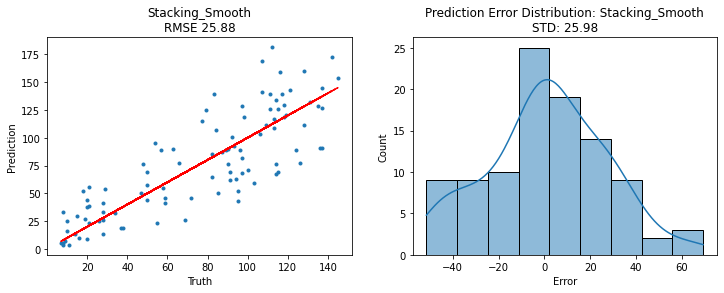

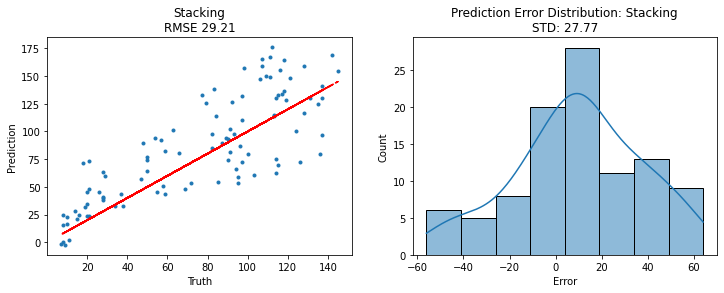

In [39]:
jar = [file.split(".")[0] for file in os.listdir(r"regressors/") if file.split(".")[1] == 'pkl']
smoothjar = [file for file in jar if "mooth" in file and 'RANSAC' not in file]
roughjar = [file for file in jar if "mooth" not in file and 'RANSAC' not in file]


params = {'final_estimator':(
                              NuSVR(),
                              SVR(),
                              AdaBoostRegressor(),
                              KNeighborsRegressor(),
                              RANSACRegressor(),
                              LinearRegression(),
                              ARDRegression(),
                              TheilSenRegressor(),
                              GradientBoostingRegressor(),
                              RandomForestRegressor(),
                              Ridge(),
                                  ),}
for n in range(2,6):
    estimators = assemble_estimators(smoothjar,n)
    model = StackingRegressor(estimators)
    fit_validate(model,params,"Stacking_Smooth",True)
    
    estimators = assemble_estimators(roughjar,n)
    model = StackingRegressor(estimators)
    fit_validate(model,params,"Stacking",False)

# Final Graph

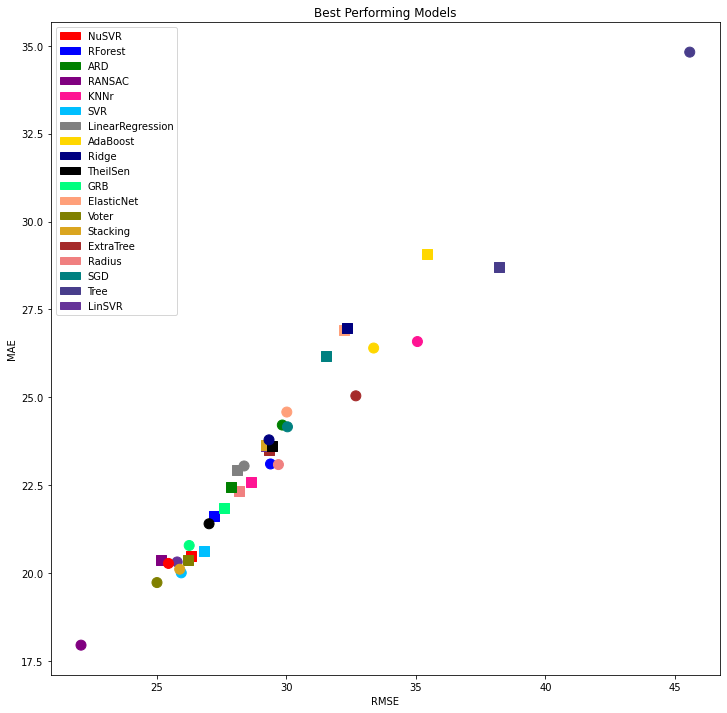

In [40]:
jar = [file.split(".")[0] for file in os.listdir(r"regressors/") if file.split(".")[1] == 'pkl']
smoothjar = [file for file in jar if "Smooth" in file or "smooth" in file]
roughjar = [file for file in jar if "Smooth" not in file and "smooth" not in file]

colors={'NuSVR':'red',
       'RForest':'blue',
       'ARD':'green',
       'RANSAC':'purple',
       'KNNr':'deeppink',
       'SVR':'deepskyblue',
       'LinearRegression':'gray',
        'AdaBoost':'gold',
        'Ridge':'navy',
        'TheilSen':'black',
        'GRB':'springgreen',
        'ElasticNet':'lightsalmon',
        'Voter':'olive',
        'Stacking':'goldenrod',
        'ExtraTree':'brown',
        'Radius':'lightcoral',
        'SGD':'teal',
        'Tree':'darkslateblue', 
        'LinSVR':'rebeccapurple'
       }

handles = list()
for key in colors.keys():
    handles.append(mpatch.Patch(color=colors[key],label=key))

rmodels,rmse,rmae,rcolor,rshape = list(), list(), list(), list(), list()
for name in roughjar:
    file = open(r"regressors/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    rmodels.append(name)
    rcolor.append(colors[name])
    rmse.append(metrics.mean_squared_error(y_val,model.predict(X_val),squared=False))
    rmae.append(metrics.mean_absolute_error(y_val,model.predict(X_val)))

smodels,smse,smae,scolor,sshape = list(), list(), list(), list(), list()
for name in smoothjar:
    file = open(r"regressors/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    scolor.append(colors[name.split("_")[0]])
    smodels.append(name.split("_")[0])
    smse.append(metrics.mean_squared_error(y_val,model.predict(X_val),squared=False))
    smae.append(metrics.mean_absolute_error(y_val,model.predict(X_val)))

plt.figure(figsize=(12,12))
plt.scatter(x=rmse,y=rmae,s=100,marker="s",c=rcolor)
plt.scatter(x=smse,y=smae,s=100,marker="o",c=scolor)
plt.xlabel("RMSE")
plt.ylabel("MAE")
plt.title("Best Performing Models")
plt.legend(handles=handles)
plt.show()

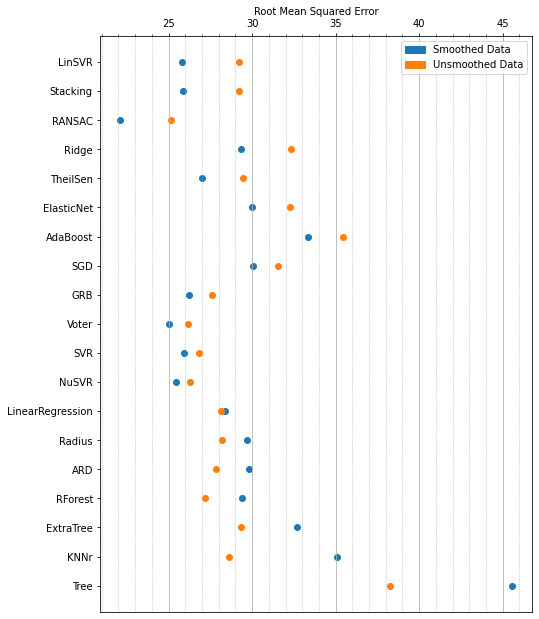

In [41]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


jar = [file.split(".")[0] for file in os.listdir(r"regressors/") if file.split(".")[1] == 'pkl']
roughjar = [file for file in jar if "mooth" not in file]

rough_scores,smooth_scores,names, diff = list(), list(), list(), list()
for name in roughjar:
    file = open(r"regressors/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    r = metrics.mean_squared_error(y_val,
                                   model.predict(X_val),
                                   squared=False
                                  )
    file = open(r"regressors/{}_Smooth.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    s = metrics.mean_squared_error(y_val,
                                   model.predict(X_val),
                                   squared=False)
    diff.append(s-r)
    names.append(name)
    rough_scores.append(r)
    smooth_scores.append(s)

df = pd.DataFrame(zip(names,rough_scores,
                      smooth_scores,diff),
                 columns=("Model","Unsmoothed",
                          "Smoothed","Difference"))

handles = list()
colors={"Smoothed Data":"tab:blue",
        "Unsmoothed Data":"tab:orange"}
for key in colors.keys():
    handles.append(mpatch.Patch(color=colors[key],
                                label=key))

df.sort_values(by="Difference",
               inplace=True,
               ascending=False)
fig= plt.figure(figsize=(6,8))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(axis='x',which='major',)
ax.grid(axis='x',which='minor',linestyle=":")
ax.set_xlabel("Root Mean Squared Error")
ax.legend(handles=handles)
scatter = ax.scatter(df["Smoothed"],
                     df["Model"],
                     c="tab:blue")
scatter = ax.scatter(df["Unsmoothed"],
                     df["Model"],
                     c="tab:orange")

# Produce Individual Graphs of leading models

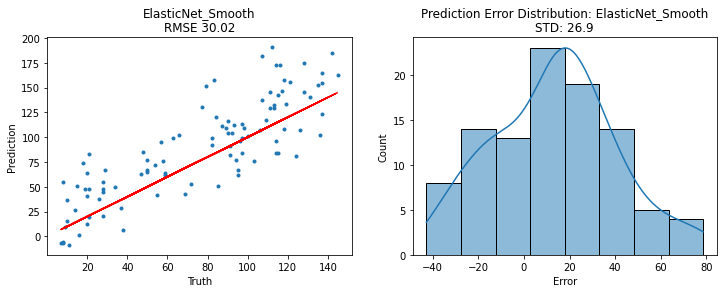

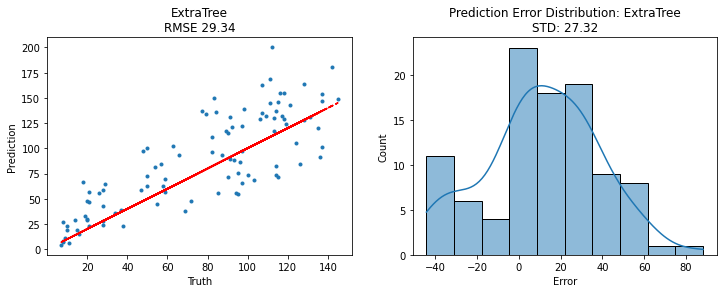

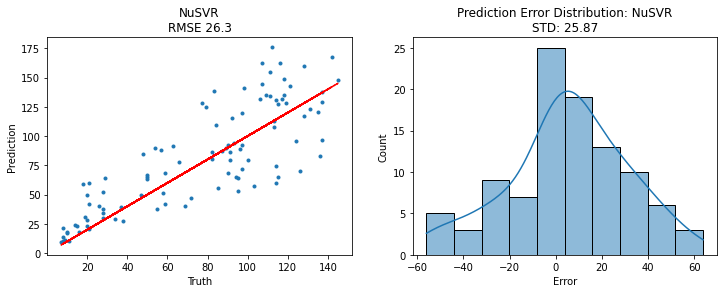

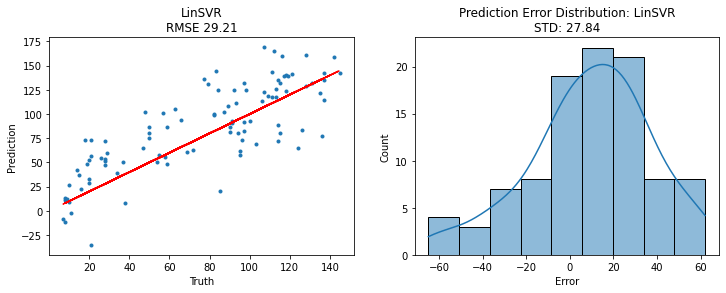

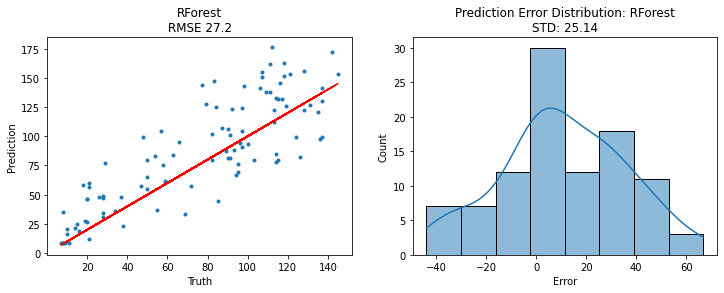

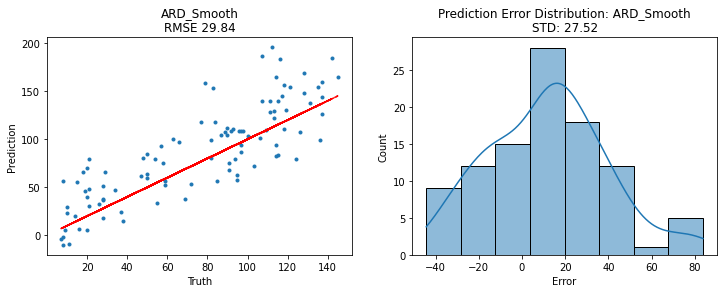

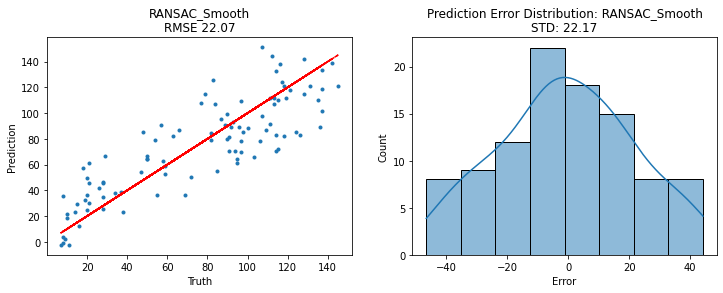

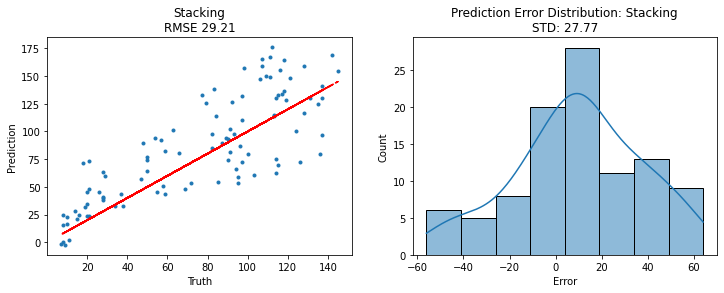

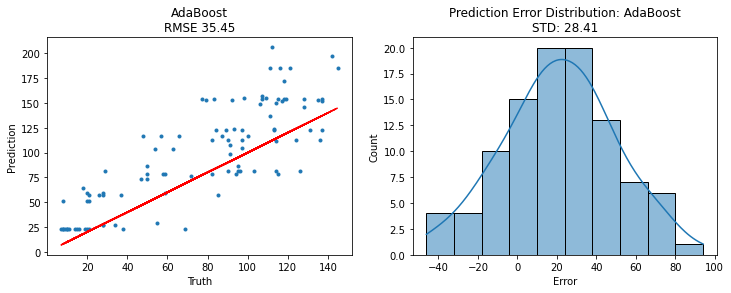

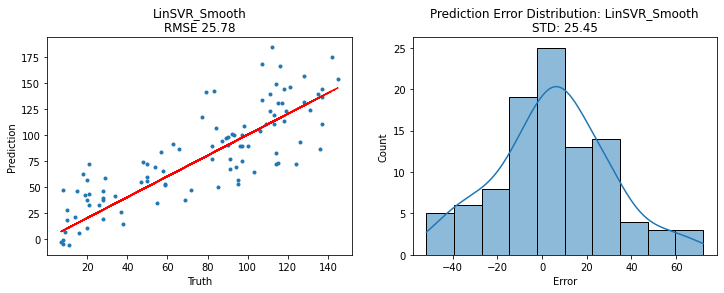

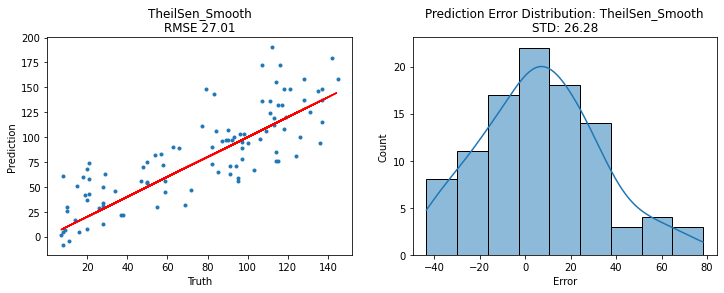

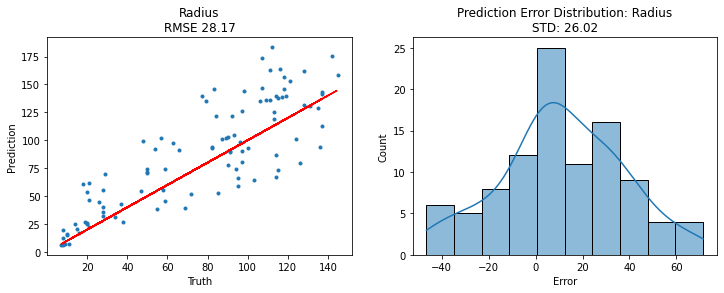

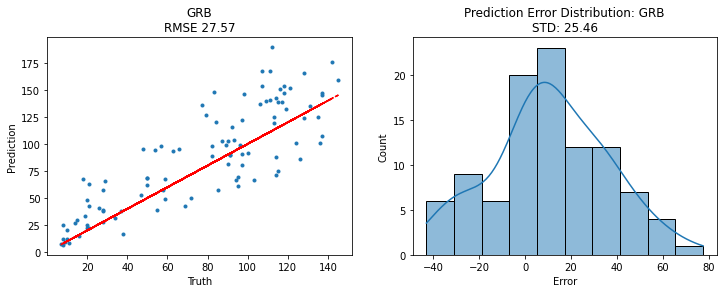

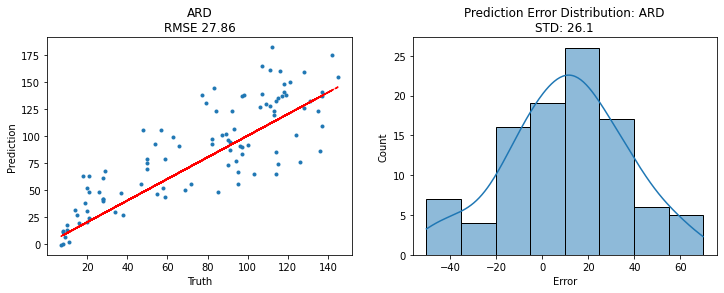

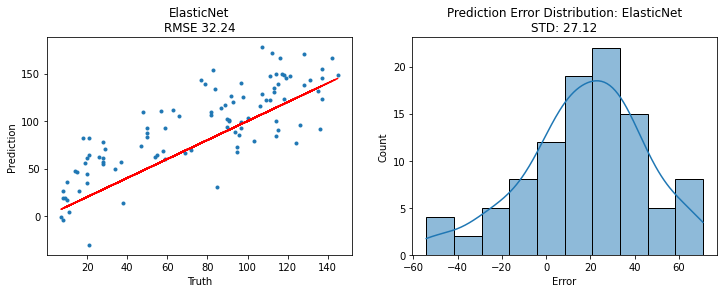

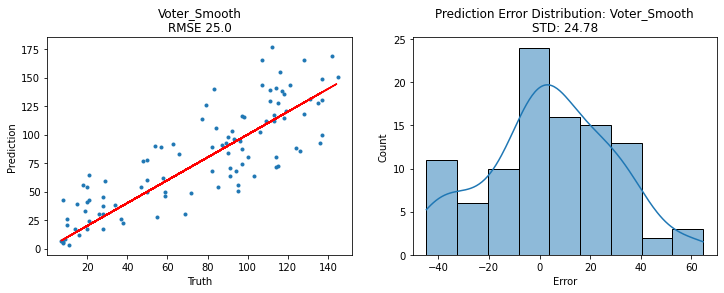

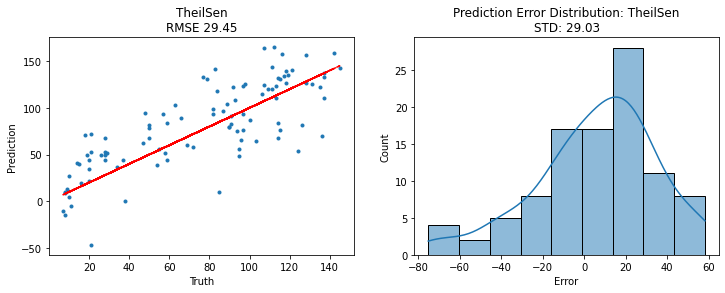

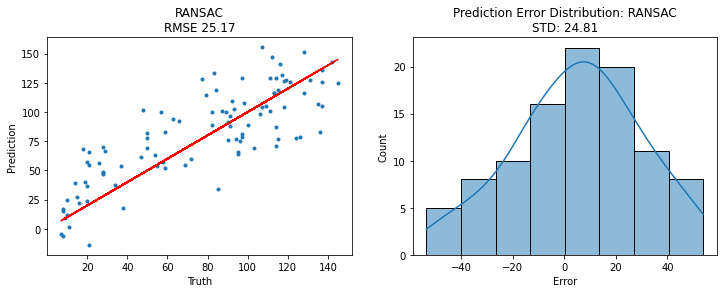

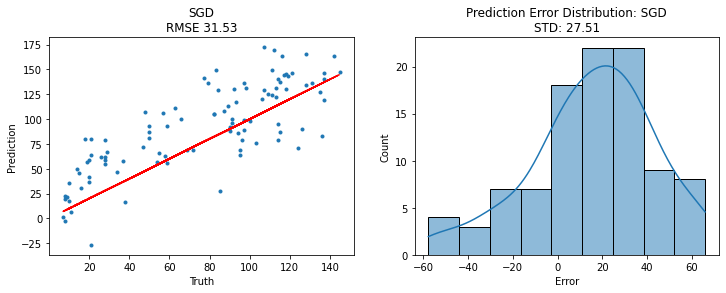

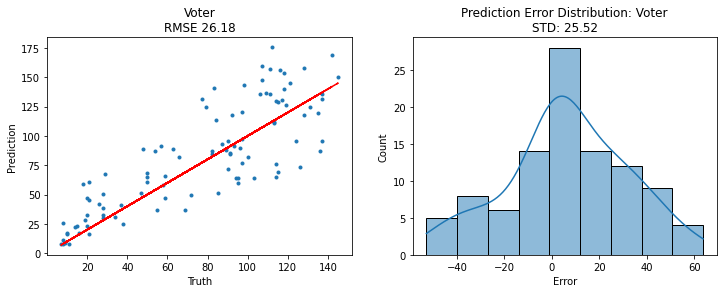

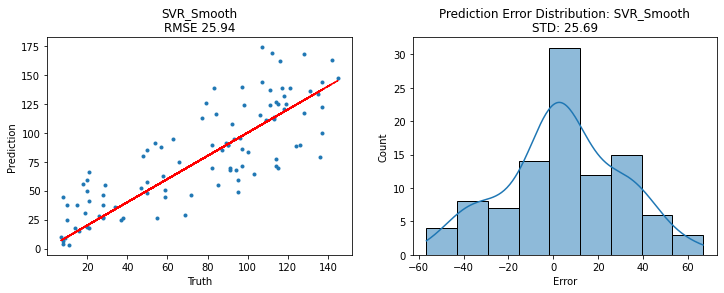

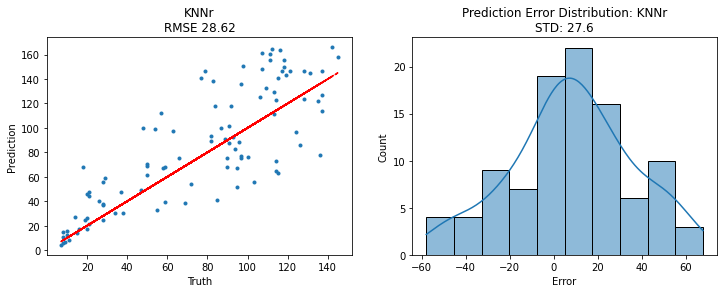

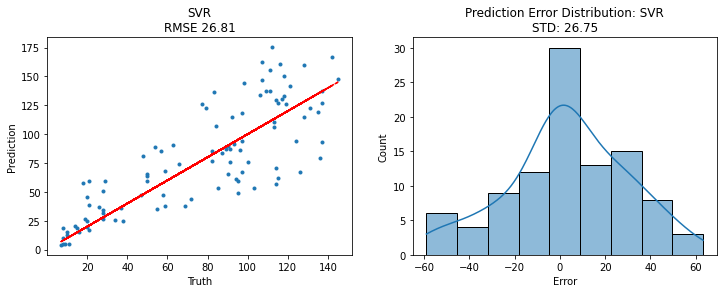

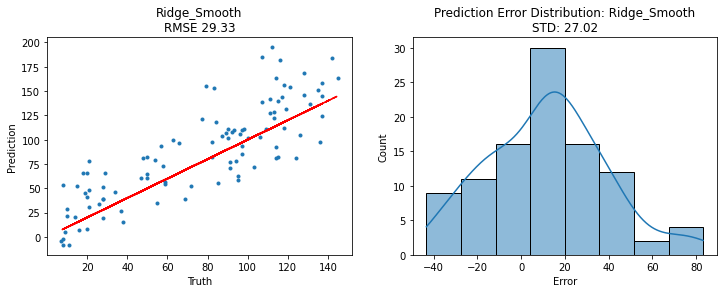

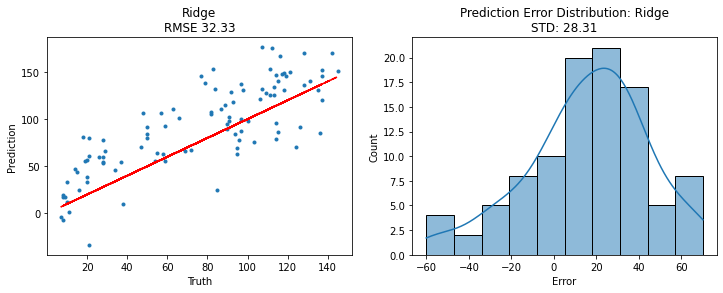

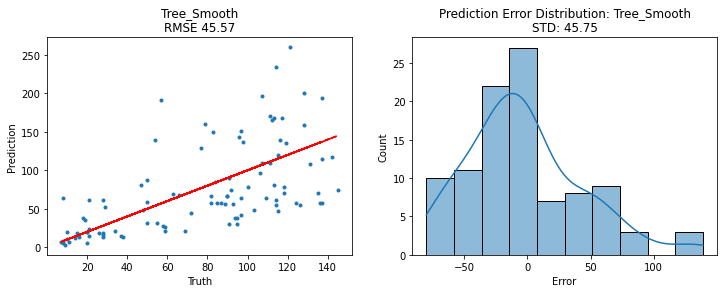

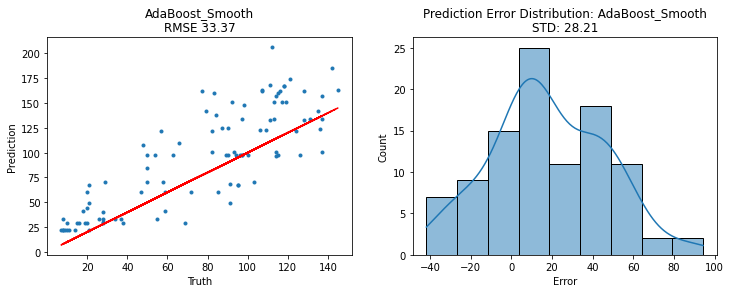

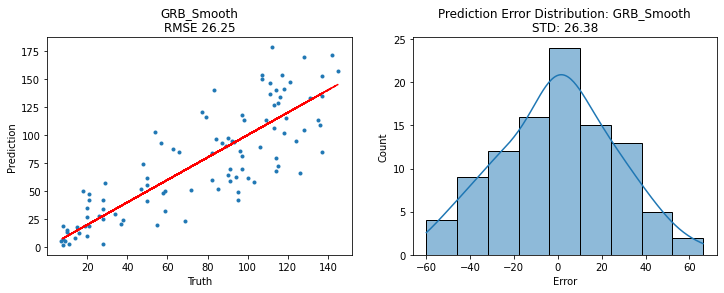

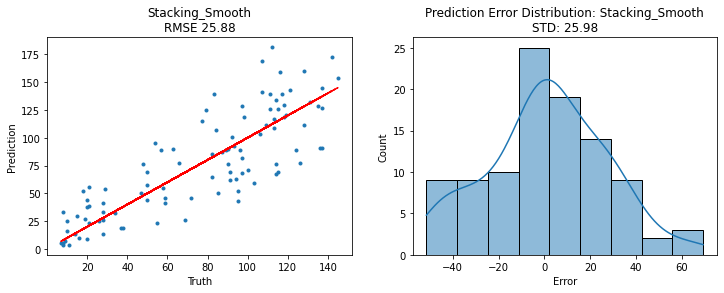

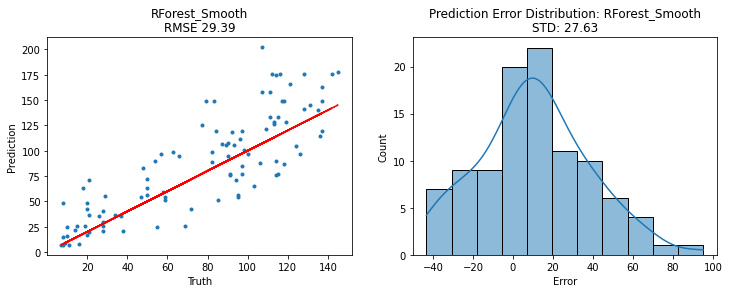

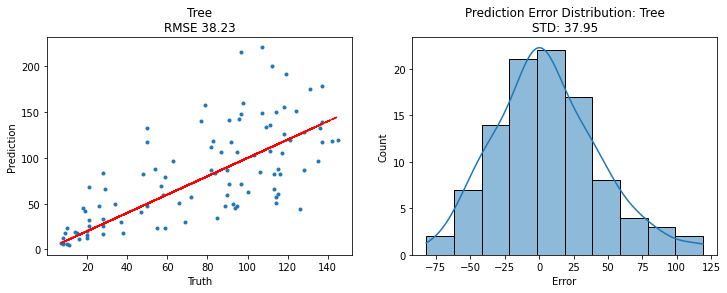

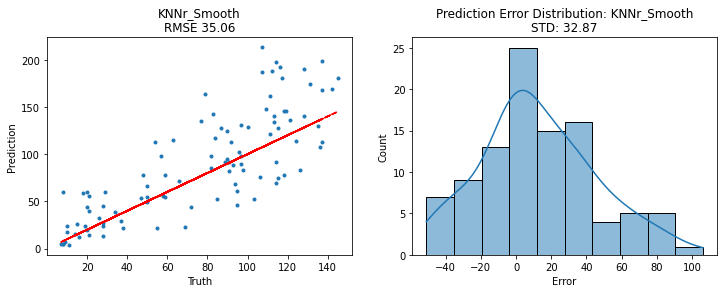

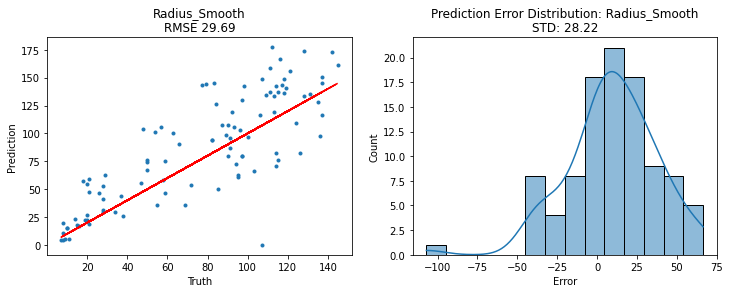

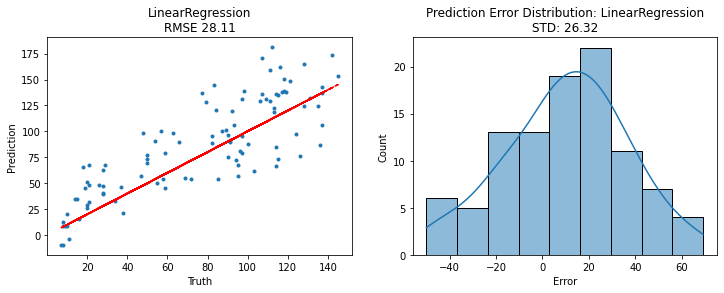

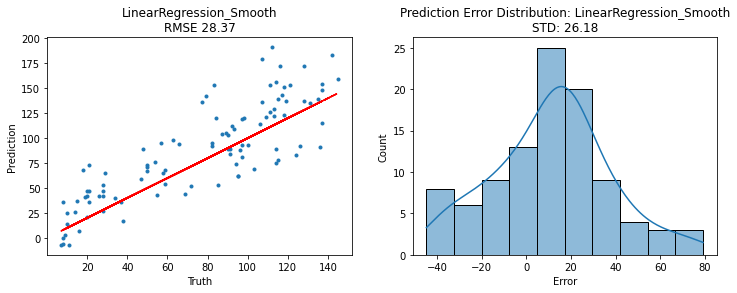

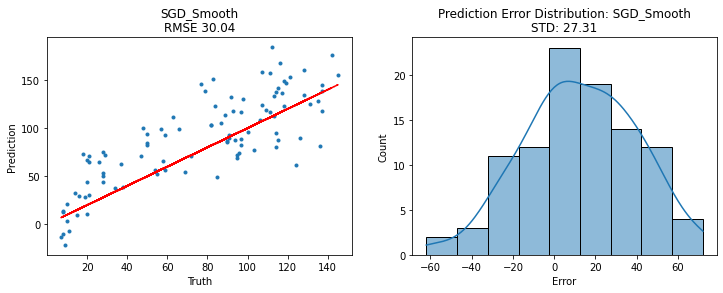

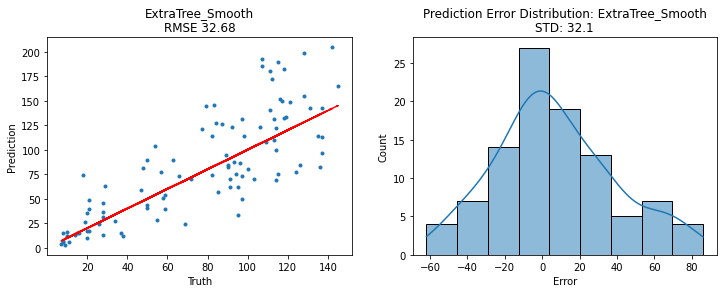

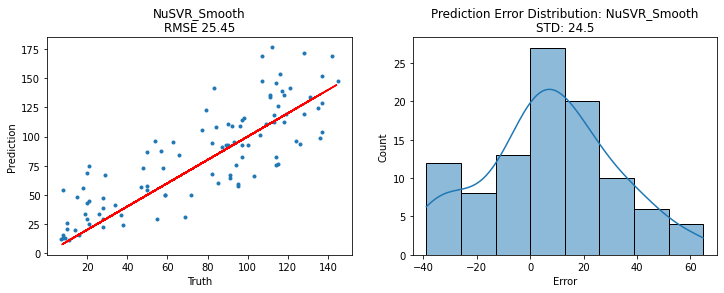

In [42]:
jar = [file.split(".")[0] for file in os.listdir(r"regressors/") if file.split(".")[1] == 'pkl']

for name in jar:
    file = open(r"regressors/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    resultplot(model,name)
    plt.show()

# Write results to file

In [43]:
jar = [file.split(".")[0] for file in os.listdir(r"regressors/") if file.split(".")[1] == 'pkl']
names, models, rmse, maes, smoothed = list(), list(), list(), list(), list()
for name in jar:
    file = open(r"regressors/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    names.append(name)
    models.append(model)
    pred_val = model.predict(X_val)
    rmse.append(metrics.mean_squared_error(y_val,pred_val,squared=False))
    maes.append(metrics.mean_absolute_error(y_val,pred_val))
    smoothed.append(len(name.split("_"))>1)
results = pd.DataFrame(zip(names,models,rmse,maes,smoothed),
                       columns=("Name","Pipeline","RMSE","MAE","Smoothed")
                      ).sort_values(by="RMSE").reset_index()
results.to_excel("Regression_Results.xlsx")
print("Done")

Done


In [ ]:
import random
engines = set(range(1,101))
print(random.sample(engines,k=5))